# Heart Disease

This is a binary classification problem. As described in the [data card](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease) on Kaggle, our task is to see if we can build a supervised model that can label whether a patient will have a heart attack, based on certain predictive factors.

## Imports and Loading Data

In [85]:
# optional: allow Jupyter to "hot reload" the Python modules I wrote, to avoid restarting the kernel after every change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("./data/heart_2022_with_nans.csv")

In [4]:
df.shape

(445132, 40)

Let's double check if we parse the CSV correctly:

In [5]:
df.head()

State     Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0  Alabama  Female     Very good                 0.0               0.0   
1  Alabama  Female     Excellent                 0.0               0.0   
2  Alabama  Female     Very good                 2.0               3.0   
3  Alabama  Female     Excellent                 0.0               0.0   
4  Alabama  Female          Fair                 2.0               0.0   

                                     LastCheckupTime PhysicalActivities  \
0  Within past year (anytime less than 12 months ...                 No   
1                                                NaN                 No   
2  Within past year (anytime less than 12 months ...                Yes   
3  Within past year (anytime less than 12 months ...                Yes   
4  Within past year (anytime less than 12 months ...                Yes   

   SleepHours RemovedTeeth HadHeartAttack  ... HeightInMeters  \
0         8.0          NaN             No  ...            NaN   
1         6.0          NaN             No  ...           1.60   
2         5.0          NaN             No  ...           1.57   
3         7.0          NaN             No  ...           1.65   
4         9.0          NaN             No  ...           1.57   

  WeightInKilograms    BMI AlcoholDrinkers HIVTesting FluVaxLast12  \
0               NaN    NaN              No         No          Yes   
1             68.04  26.57              No         No           No   
2             63.50  25.61              No         No           No   
3             63.50  23.30              No         No          Yes   
4             53.98  21.77             Yes         No           No   

  PneumoVaxEver                                  TetanusLast10Tdap  \
0            No  Yes, received tetanus shot but not sure what type   
1            No  No, did not receive any tetanus shot in the pa...   
2            No                                                NaN   
3           Yes  No, did not receive any tetanus shot in the pa...   
4           Yes  No, did not receive any tetanus shot in the pa...   

  HighRiskLastYear CovidPos  
0               No       No  
1               No       No  
2               No      Yes  
3               No       No  
4               No       No  

[5 rows x 40 columns]

## Exploratory Data Analysis

Some interesting observations I can already tell:
- lots of columns
- lots of NaN for categorical variables - will be hard to impute, but this is also a big dataset so maybe they can be dropped
- the data card stated we have a high class imbalance

### Basic Profile

In [6]:
from ydata_profiling import ProfileReport

In [13]:
profile = ProfileReport(df, title="Heart Disease Indicators Profile")
profile.to_file("Heart_Disease_Profile.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/sraza/miniforge3/envs/testenv/lib/python3.9/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'Age 80 or older'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Where are the NaNs?

In [7]:
nan_df = df[df.isna().any(axis=1)]  # show the null values in the DataFrame, if any
nan_df.shape

(199110, 40)

In [8]:
print(f"Percentage of NaN rows in the overall dataset: {round(nan_df.shape[0] / df.shape[0], 4) * 100}%")

Percentage of NaN rows in the overall dataset: 44.73%


Ok, so that's a lot of rows!

## Single Model Approaches

### Imputing Values 

For continuous features - let's replace NaNs with the mean of the column. 

For other categorical features - let's replace with the mode of the column.

With one exception - if the NaN is in the target column of `"HadHeartAttack"`, then we can just drop it - because we're already dealing with such an overly imbalanced dataset, and there's not that many rows that fall into this category (as evidenced in the profile report, there are only 3,065 rows like this, out of all 445,132).

First of all, let's see what data types are used, so we know how to detect the continuous from the categorical features:

In [9]:
df.dtypes.value_counts()

object     34
float64     6
Name: count, dtype: int64

#### Drop NaNs in the Target Column

In [10]:
TARGET_COL = "HadHeartAttack"

In [11]:
df_no_nan_targets = df.dropna(subset=[TARGET_COL])
df_no_nan_targets = df_no_nan_targets.drop_duplicates(keep="first")

#### Impute Feature Columns

In [12]:
from __future__ import annotations

import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self: DataFrameImputer):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value
        in column.

        Columns of other types are imputed with mean of column.

        Note: this class is not my own. Originally adapted from "sveitser", found on this link:
        https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
        """
    def fit(self, X: pd.DataFrame | pd.Series, y: pd.Series | np.ndarray = None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X: pd.DataFrame | pd.Series, y: pd.Series | np.ndarray = None):
        return X.fillna(self.fill)

In [13]:
features = list(df_no_nan_targets.columns)
features.remove(TARGET_COL)

In [14]:
X = df_no_nan_targets[features]
y = df_no_nan_targets[TARGET_COL]

In [15]:
X_no_nan = DataFrameImputer().fit_transform(X)

In [16]:
y_no_nan = y

In [17]:
X_no_nan[X_no_nan.isna().any(axis=1)]

Empty DataFrame
Columns: [State, Sex, GeneralHealth, PhysicalHealthDays, MentalHealthDays, LastCheckupTime, PhysicalActivities, SleepHours, RemovedTeeth, HadAngina, HadStroke, HadAsthma, HadSkinCancer, HadCOPD, HadDepressiveDisorder, HadKidneyDisease, HadArthritis, HadDiabetes, DeafOrHardOfHearing, BlindOrVisionDifficulty, DifficultyConcentrating, DifficultyWalking, DifficultyDressingBathing, DifficultyErrands, SmokerStatus, ECigaretteUsage, ChestScan, RaceEthnicityCategory, AgeCategory, HeightInMeters, WeightInKilograms, BMI, AlcoholDrinkers, HIVTesting, FluVaxLast12, PneumoVaxEver, TetanusLast10Tdap, HighRiskLastYear, CovidPos]
Index: []

[0 rows x 39 columns]

Woohoo! No more NaNs :)

### Train-Test Split

In [18]:
from sklearn.model_selection import train_test_split

In [60]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_no_nan, y_no_nan,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

### Feature Engineering and Feature Selection

In [86]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from src import util

In [23]:
X_train1.columns

Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma',
       'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
       'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing',
       'BlindOrVisionDifficulty', 'DifficultyConcentrating',
       'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands',
       'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
       'AgeCategory', 'HeightInMeters', 'WeightInKilograms', 'BMI',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [20]:
categorical_unordered_cols = [
    "State",
    "Sex",
    "RaceEthnicityCategory",
]

binary_or_categorical_ordered_cols = [
    "GeneralHealth",
    "LastCheckupTime",
    "PhysicalActivities",
    "RemovedTeeth",
    "HadAngina",
    "HadStroke",
    "HadAsthma",
    "HadSkinCancer",
    "HadCOPD",
    "HadDepressiveDisorder",
    "HadKidneyDisease",
    "HadArthritis",
    "HadDiabetes",
    "DeafOrHardOfHearing",
    "BlindOrVisionDifficulty",
    "DifficultyConcentrating",
    "DifficultyWalking",
    "DifficultyDressingBathing",
    "DifficultyErrands",
    "SmokerStatus",
    "ECigaretteUsage",
    "ChestScan",
    "AgeCategory",
    "AlcoholDrinkers",
    "HIVTesting",
    "FluVaxLast12",
    "PneumoVaxEver",
    "TetanusLast10Tdap",
    "HighRiskLastYear",
    "CovidPos",
]

continuous_cols = [
    "SleepHours",
    "MentalHealthDays",
    "PhysicalHealthDays",
    "HeightInMeters",
    "WeightInKilograms",
    "BMI",
]

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ("ordered", OrdinalEncoder(), binary_or_categorical_ordered_cols),
        ("unordered", OneHotEncoder(), categorical_unordered_cols),
        ("cont", StandardScaler(), continuous_cols),
    ]
)

### Attempt 1: LDA, I don't care at all about interactions between features

Quick notes - the concepts behind LDA are as follows (based this [StatQuest video](https://www.youtube.com/watch?v=azXCzI57Yfc)):
- supervised classification model
- leverages dims reduction
- objective function: `max(means betwen each class) / min(variation w/in each class)`
- we use some kind of solver with this ^objective, to project the data unto a new axis to make it easier to separate with a **linear** (in the case of *linear* discriminant analysis that is) **decision function**

We'll try without the SVD solver as an option - due to implementation details, it does not allow for the shrinkage (a regularization technique), which is something we probably need as this dataset has lots of features:

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

The best model set this config: {'solver': 'lsqr', 'shrinkage': 0.25, 'priors': None, 'n_components': None, 'store_covariance': True, 'tol': 1e-06, 'covariance_estimator': None, 'n_features_in_': 97, 'classes_': array(['No', 'Yes'], dtype='<U3'), 'priors_': array([0.94276201, 0.05723799]), '_max_components': 1, 'means_': array([[ 2.26511655e+00,  2.61472256e+00,  7.70928630e-01,
         1.89144270e+00,  3.39638039e-02,  3.34288869e-02,
         1.47431369e-01,  7.61639589e-02,  7.04581770e-02,
         2.01766598e-01,  3.97758835e-02,  3.25047834e-01,
         2.98216257e-01,  7.96820672e-02,  4.83551301e-02,
         1.07785786e-01,  1.37110213e-01,  3.33294472e-02,
         6.60279666e-02,  2.45621910e+00,  2.97705343e-01,
         3.53641894e-01,  6.51259112e+00,  5.86810866e-01,
         2.92020135e-01,  5.69943834e-01,  3.29248304e-01,
         9.19608139e-01,  3.95289987e-02,  5.34111249e-01,
         9.87882071e-03,  1.34072159e-02,  2.25762428e-02,
         1.15315773e-02,  2.

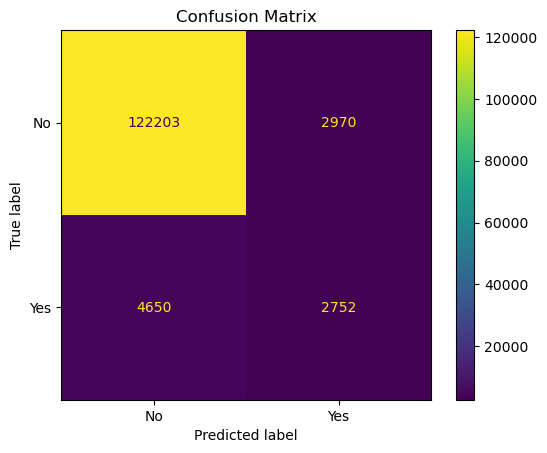

=============== ROC and AUC ================
Gini coefficient (normalized ROC AUC): 0.7545915458679331.


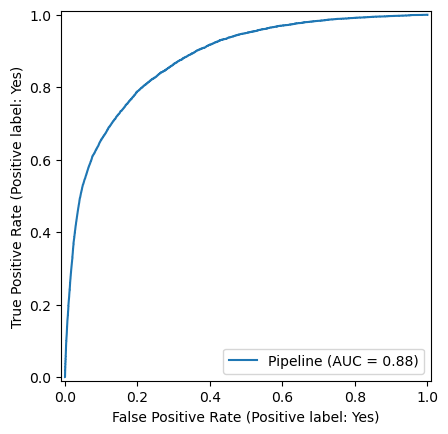

In [42]:
attempt1_results = util.run_classification_experiment(
    (X_train1, X_test1, y_train1, y_test1),
    LinearDiscriminantAnalysis(),
    preprocessor,
    param_grid={
        "classifier__solver": ["lsqr", "eigen"],
        "classifier__shrinkage": [
            "auto",  # uses Ledoit-Wolf lemma
            0.001, 0.01, 0.1, 0.25, .5, .75, .9,  # arbrirarily chosen
        ],
        "classifier__store_covariance": [True, False],  # only affects the SVD solver,
        "classifier__tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
    },
)

### Attempt 2: Same as Attempt 1, but Only with SVD

The best model set this config: {'solver': 'svd', 'shrinkage': None, 'priors': None, 'n_components': None, 'store_covariance': True, 'tol': 1e-06, 'covariance_estimator': None, 'n_features_in_': 97, 'classes_': array(['No', 'Yes'], dtype='<U3'), 'priors_': array([0.94276201, 0.05723799]), '_max_components': 1, 'means_': array([[ 2.26511655e+00,  2.61472256e+00,  7.70928630e-01,
         1.89144270e+00,  3.39638039e-02,  3.34288869e-02,
         1.47431369e-01,  7.61639589e-02,  7.04581770e-02,
         2.01766598e-01,  3.97758835e-02,  3.25047834e-01,
         2.98216257e-01,  7.96820672e-02,  4.83551301e-02,
         1.07785786e-01,  1.37110213e-01,  3.33294472e-02,
         6.60279666e-02,  2.45621910e+00,  2.97705343e-01,
         3.53641894e-01,  6.51259112e+00,  5.86810866e-01,
         2.92020135e-01,  5.69943834e-01,  3.29248304e-01,
         9.19608139e-01,  3.95289987e-02,  5.34111249e-01,
         9.87882071e-03,  1.34072159e-02,  2.25762428e-02,
         1.15315773e-02,  2.4

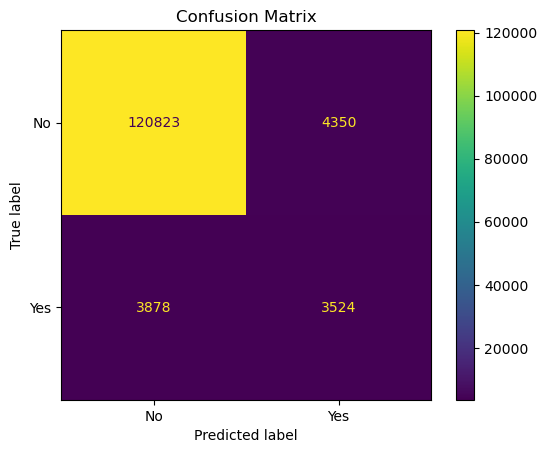

=============== ROC and AUC ================
Gini coefficient (normalized ROC AUC): 0.7541908186586652.


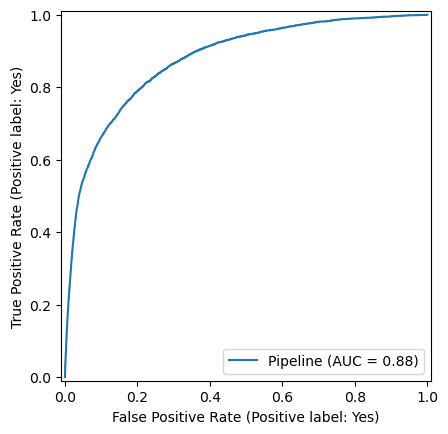

In [44]:
attempt2_results = util.run_classification_experiment(
    (X_train1, X_test1, y_train1, y_test1),
    LinearDiscriminantAnalysis(),
    preprocessor,
    param_grid={
        "classifier__solver": ["svd"],
        "classifier__shrinkage": [None],
        "classifier__store_covariance": [True, False],  # only affects the SVD solver,
        "classifier__tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
    },
)

### Attempt 3: Quadratic Discriminant Analysis

/Users/sraza/miniforge3/envs/testenv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/sraza/miniforge3/envs/testenv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/sraza/miniforge3/envs/testenv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/sraza/miniforge3/envs/testenv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/sraza/miniforge3/envs/testenv/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/sraza/miniforge3/envs/testenv/lib/python3.9/site-packages/sklearn/discriminant

The best model set this config: {'priors': None, 'reg_param': 0.25, 'store_covariance': True, 'tol': 1e-06, 'n_features_in_': 97, 'classes_': array(['No', 'Yes'], dtype=object), 'priors_': array([0.94276201, 0.05723799]), 'covariance_': [array([[ 1.86751495e+00,  2.12488699e-02,  2.13507503e-02, ...,
         6.55878290e-03,  6.45133842e-03, -5.15551384e-05],
       [ 2.12488699e-02,  7.73212978e-01, -6.56165240e-03, ...,
        -5.01403284e-02,  3.62796484e-03,  2.99596030e-02],
       [ 2.13507503e-02, -6.56165240e-03,  3.82448712e-01, ...,
         2.86959525e-02, -2.44881283e-02, -4.43792351e-02],
       ...,
       [ 6.55878290e-03, -5.01403284e-02,  2.86959525e-02, ...,
         9.97851775e-01,  3.41360943e-01, -1.90967235e-02],
       [ 6.45133842e-03,  3.62796484e-03, -2.44881283e-02, ...,
         3.41360943e-01,  9.96145394e-01,  6.35584497e-01],
       [-5.15551384e-05,  2.99596030e-02, -4.43792351e-02, ...,
        -1.90967235e-02,  6.35584497e-01,  9.96378937e-01]]), arra

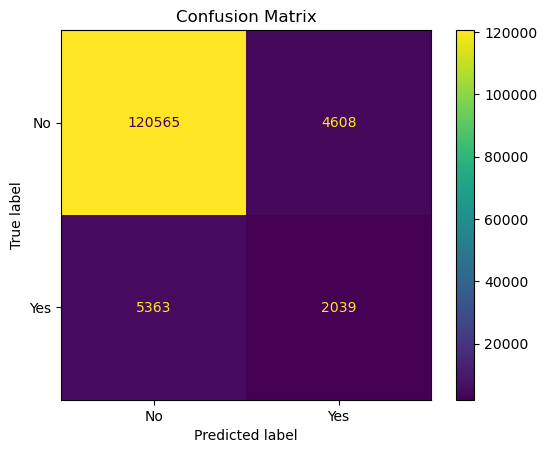

=============== ROC and AUC ================
Gini coefficient (normalized ROC AUC): 0.6848156250641302.


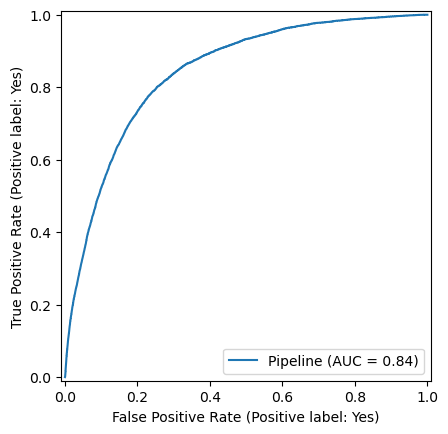

In [46]:
attempt3_results = util.run_classification_experiment(
    (X_train1, X_test1, y_train1, y_test1),
    QuadraticDiscriminantAnalysis(),
    preprocessor,
    param_grid={
        "classifier__reg_param": [
            0.001, 0.01, 0.1, 0.25, .5, .75, .9,  # arbrirarily chosen
        ],
        "classifier__store_covariance": [True, False],  # only affects the SVD solver,
        "classifier__tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
    },
)

So far, Attempt 1 and 2 are better than Attempt 3, based on AUC. And Attempt 1 and is better than 2, based on test accuracy.

But can we do better? Our precision and recall in Attempt 1 are still below `0.8`, indicating we're not yet doing well at handling the unbalanced data.

Based on the warnings raised above, we know that there is colinearity happening in this dataset. How to eliminate some of these bad features?

#### Feature Selection with Random Forest

In [23]:
from sklearn.preprocessing import LabelEncoder

In [61]:
label_enc = LabelEncoder().fit(y_train1)
y_train1_enc = label_enc.transform(y_train1)
y_test1_enc = label_enc.transform(y_test1)

In [52]:
k_values = [3, 5, 7, 11, 15]
methods = ["rf_feature_importances"]

best_k_selected_features_dicts = []

for k in k_values:
    for method in methods:
        best_k_selected_features_dicts.append(
            util.select_features(
                (X_train1, X_test1, y_train1_enc, y_test1_enc),
                preprocessor,
                method=method,
                num_features_to_select=k,
                num_trees=100,
                index_of_categorical_preprocessor=1,
            )
        )

======= Selected 3 Features To Train a Random Forest (100 Estimators, 'rf_feature_importances' method) =======
Accuracy: 0.9412006206762786
Precision: 0.46370362731365855
Recall: 0.173613383657218
F1-Score: 0.2526105442187396
ROC AUC: 0.7228614198446435
Top 3 Feature Names: ['HighRiskLastYear', 'CovidPos', 'State_California']
======= Selected 5 Features To Train a Random Forest (100 Estimators, 'rf_feature_importances' method) =======
Accuracy: 0.9393030322622357
Precision: 0.4375682686951463
Recall: 0.21184920821844808
F1-Score: 0.28547883762111664
ROC AUC: 0.7673045706495722
Top 5 Feature Names: ['State_Massachusetts', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos', 'State_California']
======= Selected 7 Features To Train a Random Forest (100 Estimators, 'rf_feature_importances' method) =======
Accuracy: 0.9379582336587573
Precision: 0.41539890198224166
Recall: 0.2056934249768502
F1-Score: 0.2751136161044322
ROC AUC: 0.791831679969286
Top 7 Feature Names: ['PneumoVaxEver', 'HIVT

In [25]:
best_15_cols = ['State_Maryland', 'State_Hawaii', 'State_Colorado', 'State_Louisiana', 'State_Montana', 'State_Arkansas', 'FluVaxLast12', 'State_Alabama', 'PneumoVaxEver', 'HIVTesting', 'State_Massachusetts', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos', 'State_California']

most_important_states = [
    col_name[6:]
    for col_name in best_15_cols
    if col_name.startswith("State_")
]


In [26]:
most_important_states

['Maryland',
 'Hawaii',
 'Colorado',
 'Louisiana',
 'Montana',
 'Arkansas',
 'Alabama',
 'Massachusetts',
 'California']

**Takeaways**: 

- looks like most the top 15 have to do with the State
- perhaps we can reduce the State column to being a boolean - i.e., is the patient residing in any of the selected states above, 

### Attempt 4: Attempt 1, but with Selected Features

In [28]:
X_no_nan[X_no_nan.isna().any(axis=1)]

Empty DataFrame
Columns: [State, Sex, GeneralHealth, PhysicalHealthDays, MentalHealthDays, LastCheckupTime, PhysicalActivities, SleepHours, RemovedTeeth, HadAngina, HadStroke, HadAsthma, HadSkinCancer, HadCOPD, HadDepressiveDisorder, HadKidneyDisease, HadArthritis, HadDiabetes, DeafOrHardOfHearing, BlindOrVisionDifficulty, DifficultyConcentrating, DifficultyWalking, DifficultyDressingBathing, DifficultyErrands, SmokerStatus, ECigaretteUsage, ChestScan, RaceEthnicityCategory, AgeCategory, HeightInMeters, WeightInKilograms, BMI, AlcoholDrinkers, HIVTesting, FluVaxLast12, PneumoVaxEver, TetanusLast10Tdap, HighRiskLastYear, CovidPos]
Index: []

[0 rows x 39 columns]

In [29]:
X_no_nan

State     Sex GeneralHealth  PhysicalHealthDays  \
0              Alabama  Female     Very good                 0.0   
1              Alabama  Female     Excellent                 0.0   
2              Alabama  Female     Very good                 2.0   
3              Alabama  Female     Excellent                 0.0   
4              Alabama  Female          Fair                 2.0   
...                ...     ...           ...                 ...   
445127  Virgin Islands  Female          Good                 0.0   
445128  Virgin Islands  Female     Excellent                 2.0   
445129  Virgin Islands  Female          Poor                30.0   
445130  Virgin Islands    Male     Very good                 0.0   
445131  Virgin Islands    Male     Very good                 0.0   

        MentalHealthDays                                    LastCheckupTime  \
0                    0.0  Within past year (anytime less than 12 months ...   
1                    0.0  Within past year (anytime less than 12 months ...   
2                    3.0  Within past year (anytime less than 12 months ...   
3                    0.0  Within past year (anytime less than 12 months ...   
4                    0.0  Within past year (anytime less than 12 months ...   
...                  ...                                                ...   
445127               3.0  Within past 2 years (1 year but less than 2 ye...   
445128               2.0  Within past year (anytime less than 12 months ...   
445129              30.0                                5 or more years ago   
445130               0.0  Within past year (anytime less than 12 months ...   
445131               1.0  Within past year (anytime less than 12 months ...   

       PhysicalActivities  SleepHours  RemovedTeeth HadAngina  ...  \
0                      No         8.0  None of them        No  ...   
1                      No         6.0  None of them        No  ...   
2                     Yes         5.0  None of them        No  ...   
3                     Yes         7.0  None of them        No  ...   
4                     Yes         9.0  None of them        No  ...   
...                   ...         ...           ...       ...  ...   
445127                Yes         6.0  None of them        No  ...   
445128                Yes         7.0  None of them        No  ...   
445129                 No         5.0        1 to 5        No  ...   
445130                 No         5.0  None of them        No  ...   
445131                Yes         5.0  None of them        No  ...   

       HeightInMeters WeightInKilograms        BMI AlcoholDrinkers HIVTesting  \
0            1.702758         83.077508  28.527883              No         No   
1            1.600000         68.040000  26.570000              No         No   
2            1.570000         63.500000  25.610000              No         No   
3            1.650000         63.500000  23.300000              No         No   
4            1.570000         53.980000  21.770000             Yes         No   
...               ...               ...        ...             ...        ...   
445127       1.650000         69.850000  25.630000             Yes        Yes   
445128       1.700000         83.010000  28.660000              No        Yes   
445129       1.700000         49.900000  17.230000             Yes         No   
445130       1.830000        108.860000  32.550000              No        Yes   
445131       1.680000         63.500000  22.600000             Yes         No   

       FluVaxLast12 PneumoVaxEver  \
0               Yes            No   
1                No            No   
2                No            No   
3               Yes           Yes   
4                No           Yes   
...             ...           ...   
445127           No            No   
445128          Yes            No   
445129           No            No   
445130          Yes           Yes   
445131           No           

In [27]:
is_top_state = list()
for state in X_no_nan["State"].values:
    if state in most_important_states:
        is_top_state.append(True)
    elif state not in most_important_states:
        is_top_state.append(False)

In [28]:
X_no_nan["Top_State"] = pd.Series(data=is_top_state)

In [29]:
X_no_nan[X_no_nan.isna().any(axis=1)]

State     Sex GeneralHealth  PhysicalHealthDays  \
441915     Puerto Rico  Female          Good                 0.0   
441916     Puerto Rico  Female          Fair                21.0   
441917     Puerto Rico  Female          Fair                25.0   
441918     Puerto Rico    Male     Excellent                 0.0   
441919     Puerto Rico  Female          Fair                20.0   
...                ...     ...           ...                 ...   
445127  Virgin Islands  Female          Good                 0.0   
445128  Virgin Islands  Female     Excellent                 2.0   
445129  Virgin Islands  Female          Poor                30.0   
445130  Virgin Islands    Male     Very good                 0.0   
445131  Virgin Islands    Male     Very good                 0.0   

        MentalHealthDays                                    LastCheckupTime  \
441915               0.0  Within past year (anytime less than 12 months ...   
441916              30.0  Within past year (anytime less than 12 months ...   
441917               0.0  Within past year (anytime less than 12 months ...   
441918               0.0  Within past year (anytime less than 12 months ...   
441919              30.0  Within past year (anytime less than 12 months ...   
...                  ...                                                ...   
445127               3.0  Within past 2 years (1 year but less than 2 ye...   
445128               2.0  Within past year (anytime less than 12 months ...   
445129              30.0                                5 or more years ago   
445130               0.0  Within past year (anytime less than 12 months ...   
445131               1.0  Within past year (anytime less than 12 months ...   

       PhysicalActivities  SleepHours            RemovedTeeth HadAngina  ...  \
441915                 No         7.0                  1 to 5        No  ...   
441916                Yes         7.0                  1 to 5        No  ...   
441917                 No         8.0  6 or more, but not all        No  ...   
441918                 No         6.0  6 or more, but not all        No  ...   
441919                 No         6.0  6 or more, but not all        No  ...   
...                   ...         ...                     ...       ...  ...   
445127                Yes         6.0            None of them        No  ...   
445128                Yes         7.0            None of them        No  ...   
445129                 No         5.0                  1 to 5        No  ...   
445130                 No         5.0            None of them        No  ...   
445131                Yes         5.0            None of them        No  ...   

       WeightInKilograms        BMI AlcoholDrinkers HIVTesting FluVaxLast12  \
441915             81.65  28.527883             Yes         No           No   
441916            104.33  42.070000              No        Yes           No   
441917             77.11  33.200000              No         No           No   
441918             65.77  23.400000             Yes        Yes           No   
441919            108.86  35.440000              No         No           No   
...                  ...        ...             ...        ...          ...   
445127             69.85  25.630000             Yes        Yes           No   
445128             83.01  28.660000              No        Yes          Yes   
445129             49.90  17.230000             Yes         No           No   
445130            108.86  32.550000              No        Yes          Yes   
445131             63.50  22.600000             Yes         No           No   

       PneumoVaxEver                                  TetanusLast10Tdap  \
441915            No  No, did not receive any tetanus shot in the pa...   
441916            No  Yes, received tetanus shot but not sure what type   
441917            No  No, did not receive any tetanus shot in the pa...   
441918            No  Yes, received tetan

In [30]:
X_no_nan["State"].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Guam', 'Puerto Rico',
       'Virgin Islands'], dtype=object)

In [31]:
X_no_nan["Top_State"].unique()

array([True, False, nan], dtype=object)

Why the hell are there still nans in this column... will drop those rows for now then...

In [32]:
X_no_nan_cleaned = DataFrameImputer().fit_transform(X_no_nan)

In [33]:
X_no_nan2 = X_no_nan_cleaned

In [34]:
X_no_nan2.tail()

State     Sex GeneralHealth  PhysicalHealthDays  \
445127  Virgin Islands  Female          Good                 0.0   
445128  Virgin Islands  Female     Excellent                 2.0   
445129  Virgin Islands  Female          Poor                30.0   
445130  Virgin Islands    Male     Very good                 0.0   
445131  Virgin Islands    Male     Very good                 0.0   

        MentalHealthDays                                    LastCheckupTime  \
445127               3.0  Within past 2 years (1 year but less than 2 ye...   
445128               2.0  Within past year (anytime less than 12 months ...   
445129              30.0                                5 or more years ago   
445130               0.0  Within past year (anytime less than 12 months ...   
445131               1.0  Within past year (anytime less than 12 months ...   

       PhysicalActivities  SleepHours  RemovedTeeth HadAngina  ...  \
445127                Yes         6.0  None of them        No  ...   
445128                Yes         7.0  None of them        No  ...   
445129                 No         5.0        1 to 5        No  ...   
445130                 No         5.0  None of them        No  ...   
445131                Yes         5.0  None of them        No  ...   

       WeightInKilograms    BMI AlcoholDrinkers HIVTesting FluVaxLast12  \
445127             69.85  25.63             Yes        Yes           No   
445128             83.01  28.66              No        Yes          Yes   
445129             49.90  17.23             Yes         No           No   
445130            108.86  32.55              No        Yes          Yes   
445131             63.50  22.60             Yes         No           No   

       PneumoVaxEver                                  TetanusLast10Tdap  \
445127            No  No, did not receive any tetanus shot in the pa...   
445128            No  Yes, received tetanus shot but not sure what type   
445129            No  No, did not receive any tetanus shot in the pa...   
445130           Yes  No, did not receive any tetanus shot in the pa...   
445131            No  Yes, received tetanus shot but not sure what type   

       HighRiskLastYear CovidPos Top_State  
445127               No      Yes     False  
445128               No       No     False  
445129               No       No     False  
445130               No      Yes     False  
445131               No       No     False  

[5 rows x 40 columns]

In [35]:
X_no_nan2["Top_State"].unique()

array([ True, False])

Ok, now the nans are gone... finally...

In [36]:
new_column_names = [
    'Top_State', 'FluVaxLast12', 'PneumoVaxEver', 'HIVTesting', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'
]

In [45]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_no_nan2[new_column_names], y_no_nan, test_size=0.3, random_state=42, shuffle=True)

In [37]:
binary_or_categorical_ordered_cols2 = [
    "Top_State",
    "HIVTesting",
    "FluVaxLast12",
    "PneumoVaxEver",
    "TetanusLast10Tdap",
    "HighRiskLastYear",
    "CovidPos",
]

In [38]:
preprocessor2 = ColumnTransformer(
    transformers=[
        ("ordered", OrdinalEncoder(), binary_or_categorical_ordered_cols2)
    ]
)

In [39]:
from sklearn import model_selection
from sklearn.pipeline import Pipeline

In [40]:
y_no_nan2 = LabelEncoder().fit_transform(y_no_nan)

In [41]:
X_no_nan2[binary_or_categorical_ordered_cols2]

Top_State HIVTesting FluVaxLast12 PneumoVaxEver  \
0            True         No          Yes            No   
1            True         No           No            No   
2            True         No           No            No   
3            True         No          Yes           Yes   
4            True         No           No           Yes   
...           ...        ...          ...           ...   
445127      False        Yes           No            No   
445128      False        Yes          Yes            No   
445129      False         No           No            No   
445130      False        Yes          Yes           Yes   
445131      False         No           No            No   

                                        TetanusLast10Tdap HighRiskLastYear  \
0       Yes, received tetanus shot but not sure what type               No   
1       No, did not receive any tetanus shot in the pa...               No   
2       No, did not receive any tetanus shot in the pa...               No   
3       No, did not receive any tetanus shot in the pa...               No   
4       No, did not receive any tetanus shot in the pa...               No   
...                                                   ...              ...   
445127  No, did not receive any tetanus shot in the pa...               No   
445128  Yes, received tetanus shot but not sure what type               No   
445129  No, did not receive any tetanus shot in the pa...               No   
445130  No, did not receive any tetanus shot in the pa...               No   
445131  Yes, received tetanus shot but not sure what type               No   

       CovidPos  
0            No  
1            No  
2           Yes  
3            No  
4            No  
...         ...  
445127      Yes  
445128       No  
445129       No  
445130      Yes  
445131       No  

[441915 rows x 7 columns]

In [61]:
params={
    "solver": "lsqr",
    "shrinkage": 0.25,
    "store_covariance": True,
    "tol": 1e-6
}

preprocessor2.fit(X_train2)

X_train2_tr = preprocessor2.transform(X_train2)
X_test2_tr = preprocessor2.transform(X_test2)

new_lda = LinearDiscriminantAnalysis(**params)

new_lda.fit(X_train2_tr, y_train2)


LinearDiscriminantAnalysis(shrinkage=0.25, solver='lsqr', store_covariance=True,
                           tol=1e-06)

#### Attempt 4 Evaluation

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

====== Accuracy and Error Rate ==============
Accuracy score: 94.41674523854422%.
Error rate: 5.58325476145578%.
========== Classification Report ============
              precision    recall  f1-score   support

          No       0.94      1.00      0.97    125173
         Yes       1.00      0.00      0.00      7402

    accuracy                           0.94    132575
   macro avg       0.97      0.50      0.49    132575
weighted avg       0.95      0.94      0.92    132575

============ Confusion Matrix ==============


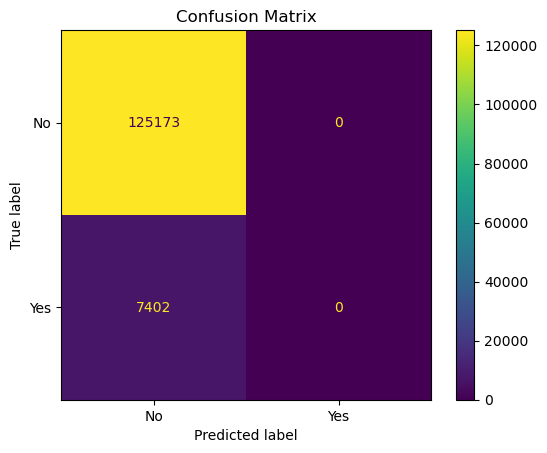

=============== ROC and AUC ================
Gini coefficient (normalized ROC AUC): 0.26813247558057296.


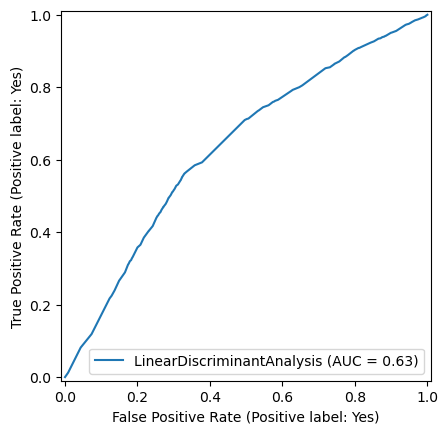

In [63]:
y_pred = new_lda.predict(X_test2_tr)

print(f"====== Accuracy and Error Rate ==============")
acc_score = metrics.accuracy_score(y_test2, y_pred)
print(f"Accuracy score: {acc_score * 100}%.")
print(f"Error rate: {(1 - acc_score) * 100}%.")

print(f"========== Classification Report ============")
print(metrics.classification_report(y_test2, y_pred, zero_division=1))

print(f"============ Confusion Matrix ==============")
_ = ConfusionMatrixDisplay.from_predictions(y_test2, y_pred)
plt.title("Confusion Matrix")
plt.show()

print(f"=============== ROC and AUC ================")
_ = RocCurveDisplay.from_estimator(new_lda, X_test2_tr, y_test2)

y_score = None
if hasattr(new_lda, "predict_proba"):
    # let's go off of probability estimates
    y_score = new_lda.predict_proba(X_test2_tr)[:, 1]
elif hasattr(new_lda, "decision_function"):
    # let's go off of decision values
    y_score = new_lda.decision_function(X_test2_tr)

roc_auc = metrics.roc_auc_score(y_test2, y_score)
gini_coefficient = 2 * roc_auc - 1
# this is normalization s.t. random guessing will be have 0 in expectation, and it is upper bounded by 1.
print(f"Gini coefficient (normalized ROC AUC): {gini_coefficient}.")
plt.show()


Looks like Attempt 4 is overall worse than Attempts 1-3 at predicting the minority class (which is whom really matters in this dataset). It looks as though my bespoke feature engineering/selection was ultimately misguided!

## Attempt 5: Say Hello to ANN

In [43]:
from sklearn.neural_network import MLPClassifier

The best model set this config: {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'batch_size': 'auto', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'power_t': 0.5, 'max_iter': 200, 'loss': 'log_loss', 'hidden_layer_sizes': [15, 5, 3], 'shuffle': True, 'random_state': 42, 'tol': 1e-06, 'verbose': False, 'warm_start': True, 'momentum': 0.9, 'nesterovs_momentum': True, 'early_stopping': True, 'validation_fraction': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-08, 'n_iter_no_change': 10, 'max_fun': 15000, 'n_features_in_': 97, '_label_binarizer': LabelBinarizer(), 'classes_': array(['No', 'Yes'], dtype='<U3'), 'n_outputs_': 1, '_random_state': RandomState(MT19937) at 0x35B471340, 'n_iter_': 38, 't_': 10579428, 'n_layers_': 5, 'out_activation_': 'logistic', 'coefs_': [array([[-0.1546897 ,  0.1551178 ,  0.42588841, ...,  0.14707352,
        -0.01702947, -0.27341164],
       [-0.14828021, -0.12177904, -0.01522316, ..., -0.05294154,
         0.12126906,  0.08331941]

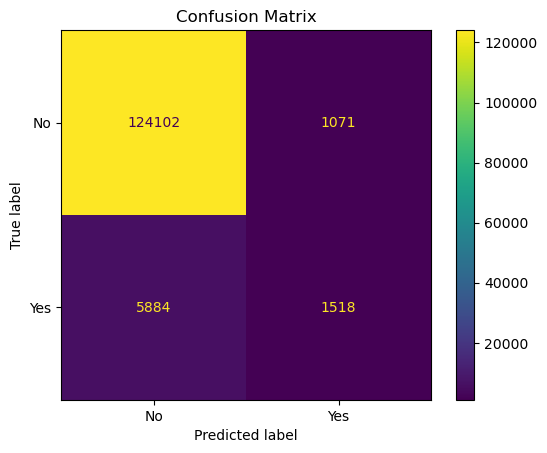

=============== ROC and AUC ================
Gini coefficient (normalized ROC AUC): 0.7675864590437365.


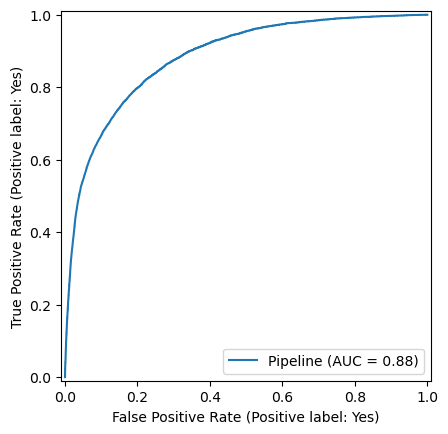

In [38]:
attempt5_results = util.run_classification_experiment(
    (X_train1, X_test1, y_train1, y_test1),
    MLPClassifier(),
    preprocessor,
    param_grid={
        "classifier__hidden_layer_sizes": [
            [15, 5, 3],
            [5, 2],
        ],
        "classifier__activation": ["relu"],
        "classifier__solver": ["adam"],
        "classifier__learning_rate": ["constant", "adaptive"],
        "classifier__random_state": [42],
        "classifier__warm_start": [True],
        "classifier__tol": [1e-6, 1e-4],
        "classifier__early_stopping": [True],
    },
)

In [39]:
attempt5_results.best_params_

{'classifier__activation': 'relu',
 'classifier__early_stopping': True,
 'classifier__hidden_layer_sizes': [15, 5, 3],
 'classifier__learning_rate': 'constant',
 'classifier__random_state': 42,
 'classifier__solver': 'adam',
 'classifier__tol': 1e-06,
 'classifier__warm_start': True}

# Heart Disease, part 2: Stacking Classifiers

## Imports

In [5]:
# optional: allow Jupyter to "hot reload" the Python modules I wrote, to avoid restarting the kernel after every change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import pandas as pd
from src import util

## Load Data

In [45]:
X_no_nan, y_no_nan, preprocessor = util.transform_heart_disease(
   "./data/heart_2022_with_nans.csv",
   mode="zain"
)

In [46]:
from sklearn.model_selection import train_test_split

In [10]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_no_nan, y_no_nan,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

## Stacking: Logistic on top of LASSO Regression 

### Attempt 6

In [47]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.pipeline import make_pipeline

In [20]:
estimators = [
    ('feat_eng', Lasso()),
]
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

In [23]:
pipeline = make_pipeline(
    preprocessor, clf
)

In [24]:
pipeline.fit(X_train1, y_train1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordered', OrdinalEncoder(),
                                                  ['GeneralHealth',
                                                   'LastCheckupTime',
                                                   'PhysicalActivities',
                                                   'RemovedTeeth', 'HadAngina',
                                                   'HadStroke', 'HadAsthma',
                                                   'HadSkinCancer', 'HadCOPD',
                                                   'HadDepressiveDisorder',
                                                   'HadKidneyDisease',
                                                   'HadArthritis',
                                                   'HadDiabetes',
                                                   'DeafOrHardOfHearing',
                                                   'BlindOrVisionDifficulty',...
                                                   'TetanusLast10Tdap',
                                                   'HighRiskLastYear',
                                                   'CovidPos']),
                                                 ('unordered', OneHotEncoder(),
                                                  ['State', 'Sex',
                                                   'RaceEthnicityCategory']),
                                                 ('cont', StandardScaler(),
                                                  ['SleepHours',
                                                   'MentalHealthDays',
                                                   'PhysicalHealthDays',
                                                   'HeightInMeters',
                                                   'WeightInKilograms',
                                                   'BMI'])])),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('feat_eng', Lasso())],
                                    final_estimator=LogisticRegression()))])

#### Evaluation

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

In [26]:
X_test1_tr = preprocessor.transform(X_test1)

====== Accuracy and Error Rate ==============
Accuracy score: 94.41674523854422%.
Error rate: 5.58325476145578%.
========== Classification Report ============
              precision    recall  f1-score   support

          No       0.94      1.00      0.97    125173
         Yes       1.00      0.00      0.00      7402

    accuracy                           0.94    132575
   macro avg       0.97      0.50      0.49    132575
weighted avg       0.95      0.94      0.92    132575

============ Confusion Matrix ==============


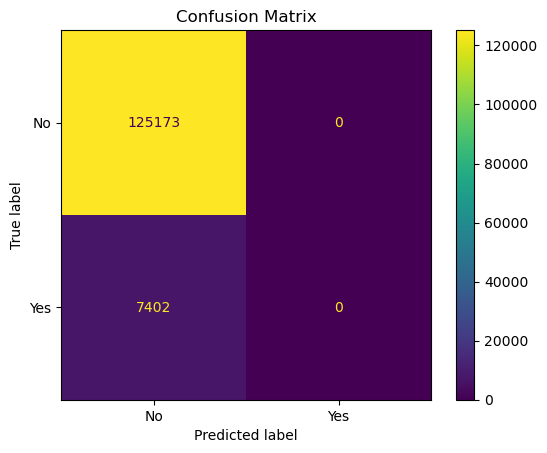

=============== ROC and AUC ================
Gini coefficient (normalized ROC AUC): 0.0.


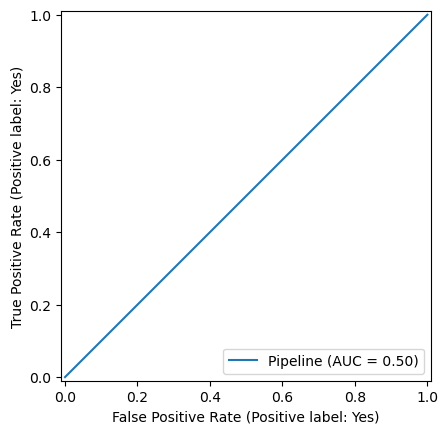

In [29]:
y_pred = pipeline.predict(X_test1)

print(f"====== Accuracy and Error Rate ==============")
acc_score = metrics.accuracy_score(y_test1, y_pred)
print(f"Accuracy score: {acc_score * 100}%.")
print(f"Error rate: {(1 - acc_score) * 100}%.")

print(f"========== Classification Report ============")
print(metrics.classification_report(y_test1, y_pred, zero_division=1))

print(f"============ Confusion Matrix ==============")
_ = ConfusionMatrixDisplay.from_predictions(y_test1, y_pred)
plt.title("Confusion Matrix")
plt.show()

print(f"=============== ROC and AUC ================")
_ = RocCurveDisplay.from_estimator(pipeline, X_test1, y_test1)

y_score = None
if hasattr(pipeline, "predict_proba"):
    # let's go off of probability estimates
    y_score = pipeline.predict_proba(X_test1)[:, 1]
elif hasattr(pipeline, "decision_function"):
    # let's go off of decision values
    y_score = pipeline.decision_function(X_test1)

roc_auc = metrics.roc_auc_score(y_test1, y_score)
gini_coefficient = 2 * roc_auc - 1
# this is normalization s.t. random guessing will be have 0 in expectation, and it is upper bounded by 1.
print(f"Gini coefficient (normalized ROC AUC): {gini_coefficient}.")
plt.show()


## Rewind - Let's Try Improving the Set of Data Transformations

Let's try rerunning the models (for the best LDA and ANN) after dropping the BMI column (as it has correlation with `Height` and `Width`), and using median to impute nans rather than the mean (in case there are outliers, then this would be most robust.)

In [92]:
categorical_unordered_cols = [
    "State",
    "Sex",
    "RaceEthnicityCategory",
]

binary_or_categorical_ordered_cols = [
    "GeneralHealth",
    "LastCheckupTime",
    "PhysicalActivities",
    "RemovedTeeth",
    "HadAngina",
    "HadStroke",
    "HadAsthma",
    "HadSkinCancer",
    "HadCOPD",
    "HadDepressiveDisorder",
    "HadKidneyDisease",
    "HadArthritis",
    "HadDiabetes",
    "DeafOrHardOfHearing",
    "BlindOrVisionDifficulty",
    "DifficultyConcentrating",
    "DifficultyWalking",
    "DifficultyDressingBathing",
    "DifficultyErrands",
    "SmokerStatus",
    "ECigaretteUsage",
    "ChestScan",
    "AgeCategory",
    "AlcoholDrinkers",
    "HIVTesting",
    "FluVaxLast12",
    "PneumoVaxEver",
    "TetanusLast10Tdap",
    "HighRiskLastYear",
    "CovidPos",
]

continuous_cols = [
    "SleepHours",
    "MentalHealthDays",
    "PhysicalHealthDays",
    "HeightInMeters",
    "WeightInKilograms",
]

preprocessor4 = ColumnTransformer(
    transformers=[
        ("ordered", OrdinalEncoder(), binary_or_categorical_ordered_cols),
        ("unordered", OneHotEncoder(), categorical_unordered_cols),
        ("cont", StandardScaler(), continuous_cols),
    ]
)

df = pd.read_csv("./data/heart_2022_with_nans.csv")

TARGET_COL = "HadHeartAttack"

df_no_nan_targets = df.dropna(subset=[TARGET_COL])
df_no_nan_targets = df_no_nan_targets.drop_duplicates(keep="first")

features = list(df_no_nan_targets.columns)
features.remove(TARGET_COL)
features.remove("BMI")  # this removes BMI

X = df_no_nan_targets[features]
y = df_no_nan_targets[TARGET_COL]

y_no_nan3 = y


And now to impute NaNs with the median, let us use the code below, which is adapted from the `fit()` method of `DataFrameImputer`:

In [93]:
fill_logic = pd.Series(
    [X[c].value_counts().index[0]
    if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
    index=X.columns
)

In [94]:
X = X.fillna(fill_logic)

In [95]:
X_no_nan3 = X

In [96]:
X_no_nan3[X_no_nan3.isna().any(axis=1)]

Empty DataFrame
Columns: [State, Sex, GeneralHealth, PhysicalHealthDays, MentalHealthDays, LastCheckupTime, PhysicalActivities, SleepHours, RemovedTeeth, HadAngina, HadStroke, HadAsthma, HadSkinCancer, HadCOPD, HadDepressiveDisorder, HadKidneyDisease, HadArthritis, HadDiabetes, DeafOrHardOfHearing, BlindOrVisionDifficulty, DifficultyConcentrating, DifficultyWalking, DifficultyDressingBathing, DifficultyErrands, SmokerStatus, ECigaretteUsage, ChestScan, RaceEthnicityCategory, AgeCategory, HeightInMeters, WeightInKilograms, AlcoholDrinkers, HIVTesting, FluVaxLast12, PneumoVaxEver, TetanusLast10Tdap, HighRiskLastYear, CovidPos]
Index: []

[0 rows x 38 columns]

### Attempt 7: The Best LDA from Attempt 1 + Improved Data

In [97]:
y_no_nan3 = LabelEncoder().fit_transform(y_no_nan3)

In [98]:
y_no_nan3

array([0, 0, 0, ..., 0, 1, 0])

In [99]:
X_train7, X_test7, y_train7, y_test7 = train_test_split(
    X_no_nan3, y_no_nan3,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

The best model set this config: {'solver': 'lsqr', 'shrinkage': 0.25, 'priors': None, 'n_components': None, 'store_covariance': True, 'tol': 1e-06, 'covariance_estimator': None, 'n_features_in_': 96, 'classes_': array([0, 1]), 'priors_': array([0.94276201, 0.05723799]), '_max_components': 1, 'means_': array([[ 2.26511655e+00,  2.61472256e+00,  7.70928630e-01,
         1.89144270e+00,  3.39638039e-02,  3.34288869e-02,
         1.47431369e-01,  7.61639589e-02,  7.04581770e-02,
         2.01766598e-01,  3.97758835e-02,  3.25047834e-01,
         2.98216257e-01,  7.96820672e-02,  4.83551301e-02,
         1.07785786e-01,  1.37110213e-01,  3.33294472e-02,
         6.60279666e-02,  2.45621910e+00,  2.97705343e-01,
         3.53641894e-01,  6.51259112e+00,  5.86810866e-01,
         2.92020135e-01,  5.69943834e-01,  3.29248304e-01,
         9.19608139e-01,  3.95289987e-02,  5.34111249e-01,
         9.87882071e-03,  1.34072159e-02,  2.25762428e-02,
         1.15315773e-02,  2.48976457e-02,  2.143

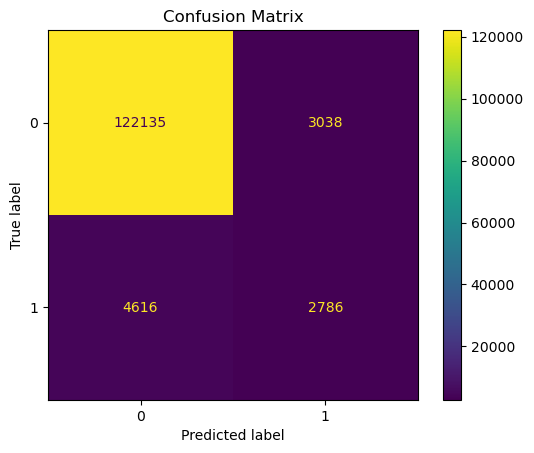

=============== ROC and AUC ================
Gini coefficient (normalized ROC AUC): 0.7547315002391728.


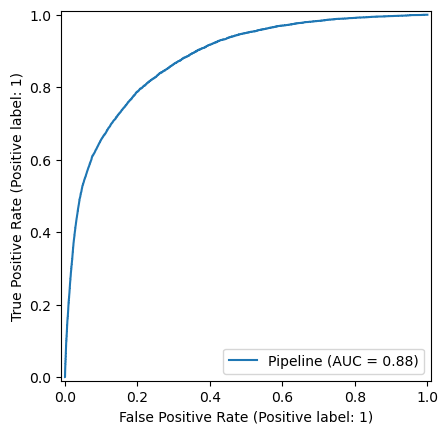

In [100]:
attempt7_results = util.run_classification_experiment(
    (X_train7, X_test7, y_train7, y_test7),
    LinearDiscriminantAnalysis(),
    preprocessor4,
    param_grid={
        # use the best hyperparameters from before
        "classifier__solver": ["lsqr"],
        "classifier__shrinkage": [0.25],
        "classifier__store_covariance": [True],  # only affects the SVD solver,
        "classifier__tol": [1e-6]
    },
)

Nice! It's hard to tell at first, but the model for attempt 7 does actually offer a slight edge over attempt 1 in performance. This makes it the best model overall:

- it's recall and F1-score are higher by 1%
- although the AUC is still 0.88, the Gini coefficient increased by about 0.002.

Might still be worth updating the Attempt 1 model with this one!

In [101]:
attempt7_results.cv_results_

{'mean_fit_time': array([1.23247929]),
 'std_fit_time': array([0.01589454]),
 'mean_score_time': array([0.45115204]),
 'std_score_time': array([0.00833803]),
 'param_classifier__shrinkage': masked_array(data=[0.25],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_classifier__solver': masked_array(data=['lsqr'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_classifier__store_covariance': masked_array(data=[True],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_classifier__tol': masked_array(data=[1e-06],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__shrinkage': 0.25,
   'classifier__solver': 'lsqr',
   'classifier__store_covariance': True,
   'classifier__tol': 1e-06}],
 'split0_test_accuracy': array([0.94187625]),
 'split1_test_accuracy': array([0.94161764]),
 'split2_test_accuracy': array([0.94106808]),
 '

### Attempt 8: The Best ANN from Attempt 5 + Improved Data

The best model set this config: {'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'batch_size': 'auto', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'power_t': 0.5, 'max_iter': 200, 'loss': 'log_loss', 'hidden_layer_sizes': [15, 5, 3], 'shuffle': True, 'random_state': 42, 'tol': 1e-06, 'verbose': False, 'warm_start': True, 'momentum': 0.9, 'nesterovs_momentum': True, 'early_stopping': True, 'validation_fraction': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-08, 'n_iter_no_change': 10, 'max_fun': 15000, 'n_features_in_': 96, '_label_binarizer': LabelBinarizer(), 'classes_': array([0, 1]), 'n_outputs_': 1, '_random_state': RandomState(MT19937) at 0x349FF1240, 'n_iter_': 17, 't_': 4732902, 'n_layers_': 5, 'out_activation_': 'logistic', 'coefs_': [array([[-0.06325923,  0.22409732,  0.22878517, ...,  0.2080375 ,
        -0.07405738,  0.00483042],
       [-0.04969898, -0.07608602,  0.00937563, ...,  0.0341149 ,
         0.03015231, -0.16837904],
       [ 0.00907263

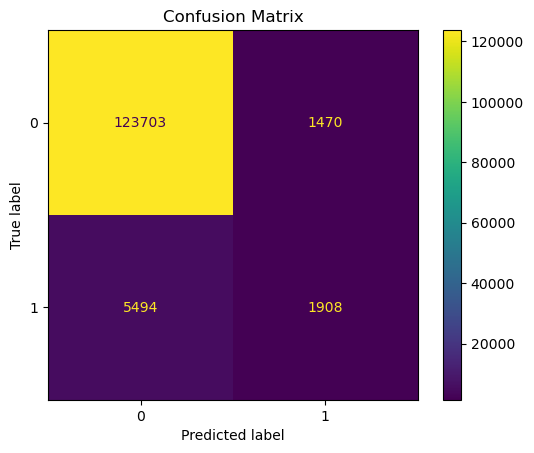

=============== ROC and AUC ================
Gini coefficient (normalized ROC AUC): 0.7669949966225937.


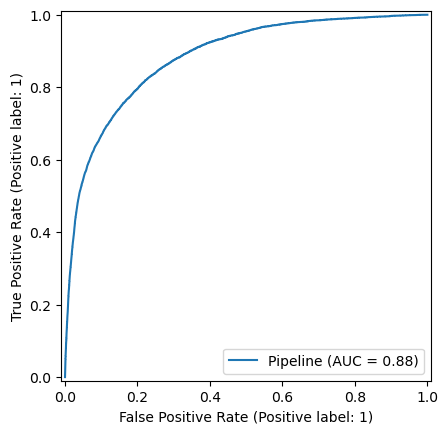

In [102]:
attempt8_results = util.run_classification_experiment(
    (X_train7, X_test7, y_train7, y_test7),
    MLPClassifier(),
    preprocessor4,
    param_grid={
        "classifier__hidden_layer_sizes": [
            [15, 5, 3],
        ],
        "classifier__activation": ["relu"],
        "classifier__solver": ["adam"],
        "classifier__learning_rate": ["constant"],
        "classifier__random_state": [42],
        "classifier__warm_start": [True],
        "classifier__tol": [1e-6],
        "classifier__early_stopping": [True],
    },
)

In [103]:
attempt8_results.cv_results_

{'mean_fit_time': array([17.71843572]),
 'std_fit_time': array([5.43978606]),
 'mean_score_time': array([0.46858759]),
 'std_score_time': array([0.0077185]),
 'param_classifier__activation': masked_array(data=['relu'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_classifier__early_stopping': masked_array(data=[True],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_classifier__hidden_layer_sizes': masked_array(data=[list([15, 5, 3])],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_classifier__learning_rate': masked_array(data=['constant'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_classifier__random_state': masked_array(data=[42],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_classifier__solver': masked_array(data=['adam'],
              mask=[False],
        fill_value='?',
   

## Tabulating Results: LDA vs. ANN

In [106]:
comparing_results = pd.DataFrame(
    data={
        "accuracy": [
            attempt7_results.cv_results_["mean_test_accuracy"][0],
            attempt8_results.cv_results_["mean_test_accuracy"][0]
        ],
        "precision": [
            attempt7_results.cv_results_["mean_test_precision"][0],
            attempt8_results.cv_results_["mean_test_precision"][0]
        ],
        "recall": [
            attempt7_results.cv_results_["mean_test_recall"][0],
            attempt8_results.cv_results_["mean_test_recall"][0]
        ],
        "f1_score": [
            attempt7_results.cv_results_["mean_test_f1"][0],
            attempt8_results.cv_results_["mean_test_f1"][0]
        ],
    },
    index=["LDA", "ANN"]
)

In [107]:
comparing_results.head()

accuracy  precision    recall  f1_score
LDA  0.941825   0.489091  0.367955  0.419935
ANN  0.946237   0.574266  0.246185  0.343076

Good stuff! With the new data transformations, it looks like the LDA still has the edge in terms of F1-score.